We will start with the pretrained embedding model `fasttext` to deal with Chinese script.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
!gunzip cc.zh.300.vec.gz

--2024-03-04 18:10:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1358817100 (1.3G) [binary/octet-stream]
Saving to: ‘cc.zh.300.vec.gz’

cc.zh.300.vec.gz    100%[===================>]   1.26G   248MB/s    in 9.0s    

2024-03-04 18:10:55 (144 MB/s) - ‘cc.zh.300.vec.gz’ saved [1358817100/1358817100]



One is the Wu-speaking region's geo name list, size 2000.
One is the Cantonese-speaking region's geo name list, size 20000.

In [ ]:
!wget https://raw.githubusercontent.com/saeziae/rime_nguphing/master/nguphing.map.dict.yaml
!wget https://raw.githubusercontent.com/rime/rime-cantonese/main/jyut6ping3.maps.dict.yaml
!wget 'https://raw.githubusercontent.com/wainshine/Chinese-Names-Corpus/master/Chinese_Names_Corpus/Chinese_Names_Corpus%EF%BC%88120W%EF%BC%89.txt'

--2024-03-04 18:10:03--  https://raw.githubusercontent.com/saeziae/rime_nguphing/master/nguphing.map.dict.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14815 (14K) [text/plain]
Saving to: ‘nguphing.map.dict.yaml’

nguphing.map.dict.y 100%[===================>]  14.47K  --.-KB/s    in 0s      

2024-03-04 18:10:03 (29.3 MB/s) - ‘nguphing.map.dict.yaml’ saved [14815/14815]

--2024-03-04 18:10:03--  https://raw.githubusercontent.com/rime/rime-cantonese/main/jyut6ping3.maps.dict.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
corpus="nguphing.map.dict.yaml" #2k
#corpus="jyut6ping3.maps.dict.yaml" #20k
#corpus="Chinese_Names_Corpus（120W）.txt" #1m2

In [ ]:
names=[]
import random
'''
with open(corpus,"r",encoding="utf-8") as f:
  x=f.readlines()[3:]
  names=[i.rstrip() for i in x]

random.shuffle(names)
names=names[:10000]
'''
# nguphing.map.dict.yaml is too small, try jyut6ping3.maps.dict.yaml
with open(corpus,"r",encoding="utf-8") as f:
  while True:
    x=f.readline()
    if x[0] == ".": break # Contents start after "..."/blank line
  while True:
    x=f.readline()
    if not x: break
    if x.rstrip() != "":
      names.append(x.split("\t")[0].rstrip()) # The first column of the TSV list is needed

print(names[:10])

['上海', '黃浦', '南京東路', '外灘', '半淞園路', '小東門', '豫園', '老西門', '五里橋', '打浦橋']


In [ ]:
import re

def filter_used_chinese_characters(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    chinese_characters = re.findall(r'[\u4e00-\u9fff]', text)
    filtered_text = ''.join(chinese_characters)
    return tuple(filtered_text)

filtered_characters = filter_used_chinese_characters(corpus)

In [ ]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
ft = KeyedVectors.load_word2vec_format('cc.zh.300.vec', limit=500000)

In [ ]:
filtered_embeddings = {}
for word in ft.index_to_key:
    if word in filtered_characters and len(word) == 1:
        filtered_embeddings[word] = ft[word]

filtered_embeddings['。'] = np.zeros(300) #end of word indicator

#A dirty work-around to read filtered_embeddings as keyedVectors
output_file_path = 'filtered_embeddings.vec'
with open(output_file_path, 'w', encoding='utf-8') as f:
    # Write the header containing the number of vectors and their dimensionality
    f.write(f"{len(filtered_embeddings)} 300\n")

    # Write each word and its corresponding embedding vector
    for word, vector in filtered_embeddings.items():
        f.write(f"{word} {' '.join(str(v) for v in vector)}\n")
ft = KeyedVectors.load_word2vec_format(output_file_path)

In [ ]:
# Function to convert characters to embeddings
def char_to_vector(char):
    try:
        return ft[char]
    except KeyError:
        # If character not found in embeddings, return a zero vector
        return np.zeros(300)
#char_to_vector("學")

In [ ]:
import torch
#taken from our example in class, modified
words=names
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [[0]*300] * block_size
    for ch in w+"。":
      ix = char_to_vector(ch)
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X=np.array(X)
  Y=np.array(Y)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  X = X.float()
  Y = Y.float()
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
m = int(0.9*len(words))
n = int(0.95*len(words))

Xtr, Ytr = build_dataset(words[:m])
Xde, Yde = build_dataset(words[m:n])
Xte, Yte = build_dataset(words[n:])


torch.Size([5596, 4, 300]) torch.Size([5596, 300])
torch.Size([308, 4, 300]) torch.Size([308, 300])
torch.Size([307, 4, 300]) torch.Size([307, 300])


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

lossi = []
stepi = []
devlossi = []

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out*100.0

# Initialize the model
input_size = 300
hidden_size = 300
output_size = 300

model = RNNModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss() # see note on the next block
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 20
batch_size = 32
inputs = Xtr
targets = Ytr
inputsd = Xde
targetsd = Yde

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    random.shuffle(inputs)
    for i in range(0, len(inputs), batch_size):
        batch_inputs = inputs[i:i+batch_size]
        batch_targets = targets[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_inputs.size(0)

    epoch_loss = running_loss / len(inputs)

    model.eval()
    running_loss = 0.0
    random.shuffle(inputsd)
    with torch.no_grad():
      for i in range(0, len(inputsd), batch_size):
          batch_inputs = inputsd[i:i+batch_size]
          batch_targets = targetsd[i:i+batch_size]
          outputs = model(batch_inputs)
          loss = criterion(outputs, batch_targets)
          running_loss += loss.item() * batch_inputs.size(0)
    epoch_loss_dev = running_loss / len(inputsd)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, dev Loss: {epoch_loss_dev:.4f}")
    stepi.append(epoch)
    lossi.append(epoch_loss)
    devlossi.append(epoch_loss_dev)

Epoch [1/20], Loss: 30.7364, dev Loss: 21.5012
Epoch [2/20], Loss: 18.2491, dev Loss: 17.2413
Epoch [3/20], Loss: 13.2837, dev Loss: 15.5643
Epoch [4/20], Loss: 9.6228, dev Loss: 15.0651
Epoch [5/20], Loss: 5.9572, dev Loss: 11.8265
Epoch [6/20], Loss: 3.3342, dev Loss: 8.7122
Epoch [7/20], Loss: 1.6221, dev Loss: 6.0835
Epoch [8/20], Loss: 0.8634, dev Loss: 3.2974
Epoch [9/20], Loss: 0.4546, dev Loss: 1.1847
Epoch [10/20], Loss: 0.1940, dev Loss: 0.5810
Epoch [11/20], Loss: 0.0942, dev Loss: 0.1089
Epoch [12/20], Loss: 0.0446, dev Loss: 0.0171
Epoch [13/20], Loss: 0.0286, dev Loss: 0.0169
Epoch [14/20], Loss: 0.0239, dev Loss: 0.0169
Epoch [15/20], Loss: 0.0231, dev Loss: 0.0170
Epoch [16/20], Loss: 0.0187, dev Loss: 0.0169
Epoch [17/20], Loss: 0.0169, dev Loss: 0.0169
Epoch [18/20], Loss: 0.0167, dev Loss: 0.0169
Epoch [19/20], Loss: 0.0167, dev Loss: 0.0169
Epoch [20/20], Loss: 0.0167, dev Loss: 0.0169


We are not using cross entropy like the prototype because the prototype saw it as a classification-like task but this is not.


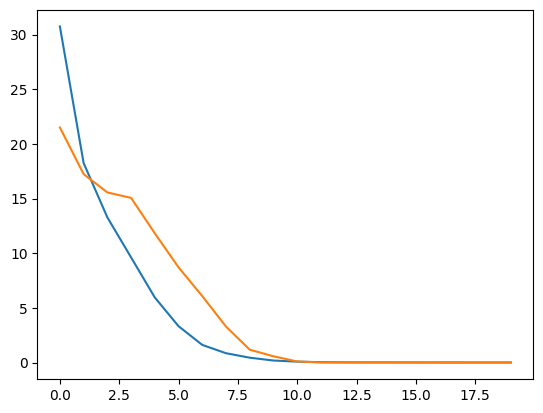

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)
plt.plot(stepi, devlossi)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
import random
# Evaluation function
def evaluate_model(model, criterion, X_test, Y_test, batch_size):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(X_test), batch_size):
            batch_inputs = X_test[i:i+batch_size]
            batch_targets = Y_test[i:i+batch_size]

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)

            total_loss += loss.item() * batch_inputs.size(0)

    avg_loss = total_loss / len(X_test)
    return avg_loss

# Evaluate the model
test_loss = evaluate_model(model, criterion, Xte, Yte, 1)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 11.7391


In [ ]:
def embedding_to_word(embedding):
    # Get nearest neighbor word
    word = ft.most_similar(embedding)
    return word

def generate_words(model, length=10):
    generated_word = ""
    input_chars = [np.random.rand(300),np.random.rand(300),np.random.rand(300)]  # Randomly generate a vector as starting character

    with torch.no_grad():
        for _ in range(length):
            input_tensor = torch.tensor([input_chars], dtype=torch.float)
            output = model(input_tensor)
            next_char_embedding = output.squeeze().numpy()
            next_char = embedding_to_word(next_char_embedding)[0][0]
            generated_word += next_char
            input_chars = input_chars[1:] + [char_to_vector(next_char)]
            if next_char == "。": break
    return generated_word

# Example usage:
for _ in range(20):
  generated_word = generate_words(model,random.randint(1,6))
  print(generated_word)
  #print(len(generated_word))


首臨侖學沐震
疇戰疇
關滸勝柏崙堰
一劍
疇
盈臘站疇界
盈滸勝柏
蛟滄欽履餘
疇臨侖鞋
戰角蘇
一
蘇嶼琳秋嶼段
疇滸疇
貴涯共麥寺
疇
運疇全洪
宣
疇寶碼荷
疇戰杜磐
劍欽全黎


<ipython-input-17-9be8217b8e72>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  input_tensor = torch.tensor([input_chars], dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


These generated names are somewhat not non sense, but lack natualness.